In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.widgets import Cursor

from pathlib import Path
import sys

import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from metpy import constants

from skimage.measure import label


In [41]:
import datetime
#--------------------------------------------------------------------------------------------------
# my datetime stuff
def my_datetime(input: list, time_delta=None, format=None, summary_file=False):

    """
        Inputs: input (list) list of [YY, MM, DD, HH, MM, SS]

                time_delta: (list)  -> [hours, minutes, seconds]
                                
                                or
                                    ->  [Days, hours, minutes, seconds]
                                    
                format:  (string)   ->  '%Y-%m-%d::%H-%M'
                
                                or
                                    ->  '%Y%d_%H%M'  (usefull for WoFS files)

        returns:  Datetime object or string if format is supplied.
        
    """
    try:
        hhmm = datetime.datetime(*input)
    except ValueError:
        print(f"Input is invalid, need YYMMDDHHMM {input}")
        return None
        
    if time_delta == None:
        
        if format == None:
            return hhmm
        else:
            return hhmm.strftime(format)
    
    else:
        
        if len(time_delta) == 3:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2])
        else:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2], seconds=time_delta[3])
            
        if format == None and summary_file == False:
            
            return hhmm + timeD
            
        else:
            
            if summary_file:

                return f"{hhmm.strftime('%Y%m%d_%H%M')}_{(hhmm+timeD).strftime('%H%M')}"

            else:  
                return (hhmm+timeD).strftime(format)

print( my_datetime([2024,5,7,19], time_delta=[0,0,65]) )
print( my_datetime([2024,5,7,19], time_delta=[0,0,65], summary_file=True ))

2024-05-07 20:05:00
20240507_1900_2005


In [21]:
# New section to "count" storms

def get_counts(ds, ens, cref_thresh =[45,], field_name='comp_dz'):

    if ens == 1:

        count = np.zeros( (len(cref_thresh),), dtype='int')

        for m, cref in enumerate(cref_thresh):

            mask_cref = np.where(ds[field_name] >= cref, True, False)
    
            f_mask = mask_cref.astype(np.int8)

            mpas_label_array, count[m] = label(f_mask, connectivity=2, return_num = True)
                
    else:
            
        count = np.zeros( (len(cref_thresh), ens,), dtype='int')

        for m, cref in enumerate(cref_thresh):

            mask_cref = np.where(ds[field_name] > cref, True, False)
    
            f_mask = mask_cref.astype(np.int8)

            for n in np.arange(ens):
                mpas_label_array, count[m,n] = label(f_mask[n], connectivity=2, return_num = True)
        
    return count


Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/1900
Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/1900
Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900
Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900


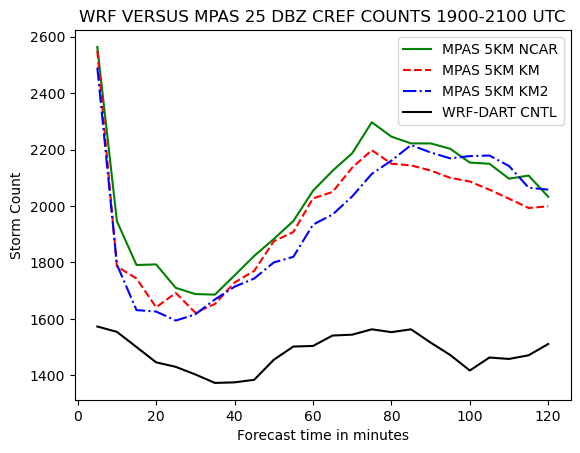

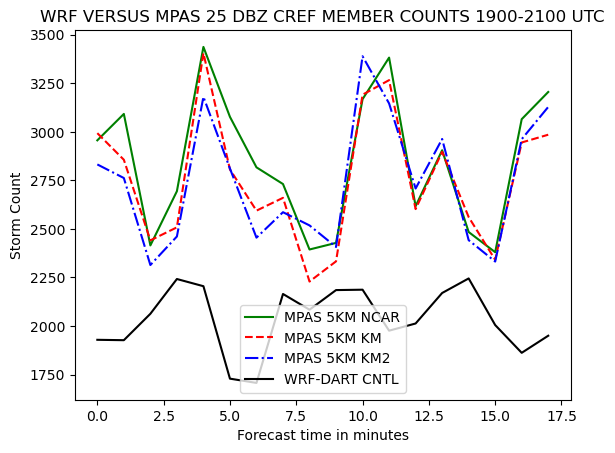

In [68]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18
cref_thresh = [25,]

runs  = [
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/1900',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/1900',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900',
         '/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900'
        ]

counts  = np.zeros((len(runs), ens, nstep), dtype='int')

for r, run in enumerate(runs):

    print(f"Now computing stats for {run}")
    
    for n in np.arange(nstep):

        min = int(n*5)
    
        file_string = my_datetime([2024,5,7,19], time_delta=[0,0,min], summary_file=True)
    
    # MPAS
        
        ds = xr.open_dataset(os.path.join(run, f"wofs_ALL_{n:02}_{file_string}.nc"))
    
        counts[r,:,n] = get_counts(ds, ens, cref_thresh = cref_thresh)
        
        ds.close()


# for n in np.arange(nstep):

#     min = int(n*5)

#     file_string = my_datetime([2024,5,7,19], time_delta=[0,0,min], summary_file=True)

#     print(f"{file_string}:  5KM_NCAR: {counts[0].sum(axis=0)[n]:03}  5KM_KM: {counts[1].sum(axis=0)[n]:03}  5KM_KM2: {counts[2].sum(axis=0)[n]:03}")

time = 5*np.arange(nstep)
plt.plot(time[1:], counts[0].sum(axis=0)[1:], color='g', label='MPAS 5KM NCAR')
plt.plot(time[1:], counts[1].sum(axis=0)[1:], color='r', linestyle='--', label='MPAS 5KM KM')
plt.plot(time[1:], counts[2].sum(axis=0)[1:],  color='b', linestyle='-.', label='MPAS 5KM KM2')
plt.plot(time[1:], counts[3].sum(axis=0)[1:],  color='k', label='WRF-DART CNTL')

plt.title(f"WRF VERSUS MPAS {cref_thresh[0]} DBZ CREF COUNTS 1900-2100 UTC")
plt.xlabel('Forecast time in minutes')
plt.ylabel('Storm Count')
plt.legend();
plt.show();

time = np.arange(ens)
plt.plot(time, counts[0].sum(axis=1), color='g', label='MPAS 5KM NCAR')
plt.plot(time, counts[1].sum(axis=1), color='r', linestyle='--', label='MPAS 5KM KM')
plt.plot(time, counts[2].sum(axis=1),  color='b', linestyle='-.', label='MPAS 5KM KM2')
plt.plot(time, counts[3].sum(axis=1),  color='k', label='WRF-DART CNTL')

plt.title(f"WRF VERSUS MPAS {cref_thresh[0]} DBZ CREF MEMBER COUNTS 1900-2100 UTC")
plt.xlabel('Member')
plt.ylabel('Storm Count')
plt.legend();

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2000
Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2000
Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2000
Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000


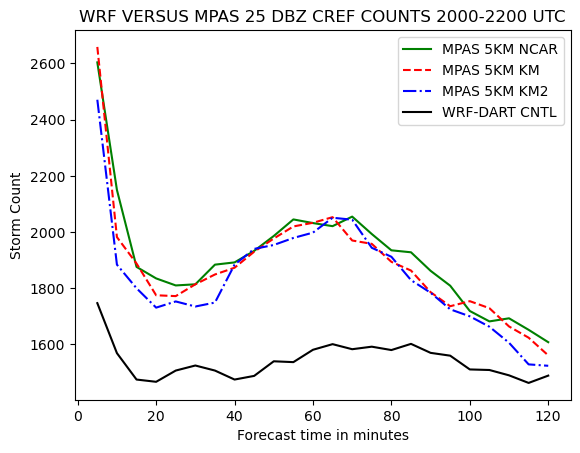

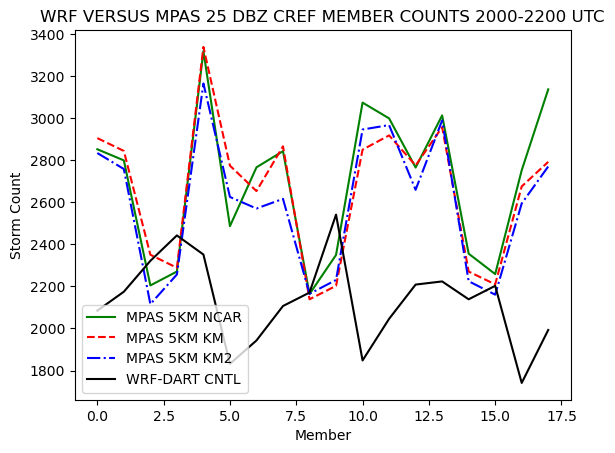

In [69]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18
min = n*5
mem = 10

runs  = [
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2000',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2000',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2000',
         '/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000'
        ]

dt_string = [2024,5,7,20]

counts  = np.zeros((len(runs), ens, nstep), dtype='int')

for r, run in enumerate(runs):

    print(f"Now computing stats for {run}")
    
    for n in np.arange(nstep):

        min = int(n*5)
    
        file_string = my_datetime(dt_string, time_delta=[0,0,min], summary_file=True)
    
    # MPAS
        
        ds = xr.open_dataset(os.path.join(run, f"wofs_ALL_{n:02}_{file_string}.nc"))
    
        counts[r,:,n] = get_counts(ds, ens, cref_thresh = cref_thresh)
        
        ds.close()


# for n in np.arange(nstep):

#     min = int(n*5)

#     file_string = my_datetime([2024,5,7,19], time_delta=[0,0,min], summary_file=True)

#     print(f"{file_string}:  5KM_NCAR: {counts[0].sum(axis=0)[n]:03}  5KM_KM: {counts[1].sum(axis=0)[n]:03}  5KM_KM2: {counts[2].sum(axis=0)[n]:03}")

time = 5*np.arange(nstep)
plt.plot(time[1:], counts[0].sum(axis=0)[1:], color='g', label='MPAS 5KM NCAR')
plt.plot(time[1:], counts[1].sum(axis=0)[1:], color='r', linestyle='--', label='MPAS 5KM KM')
plt.plot(time[1:], counts[2].sum(axis=0)[1:],  color='b', linestyle='-.', label='MPAS 5KM KM2')
plt.plot(time[1:], counts[3].sum(axis=0)[1:],  color='k', label='WRF-DART CNTL')

plt.title(f"WRF VERSUS MPAS {cref_thresh[0]} DBZ CREF COUNTS 2000-2200 UTC")
plt.xlabel('Forecast time in minutes')
plt.ylabel('Storm Count')
plt.legend()
plt.show();

time = np.arange(ens)
plt.plot(time, counts[0].sum(axis=1), color='g', label='MPAS 5KM NCAR')
plt.plot(time, counts[1].sum(axis=1), color='r', linestyle='--', label='MPAS 5KM KM')
plt.plot(time, counts[2].sum(axis=1),  color='b', linestyle='-.', label='MPAS 5KM KM2')
plt.plot(time, counts[3].sum(axis=1),  color='k', label='WRF-DART CNTL')

plt.title(f"WRF VERSUS MPAS {cref_thresh[0]} DBZ CREF MEMBER COUNTS 2000-2200 UTC")
plt.xlabel('Member')
plt.ylabel('Storm Count')
plt.legend();

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100
Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2100
Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2100
Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100


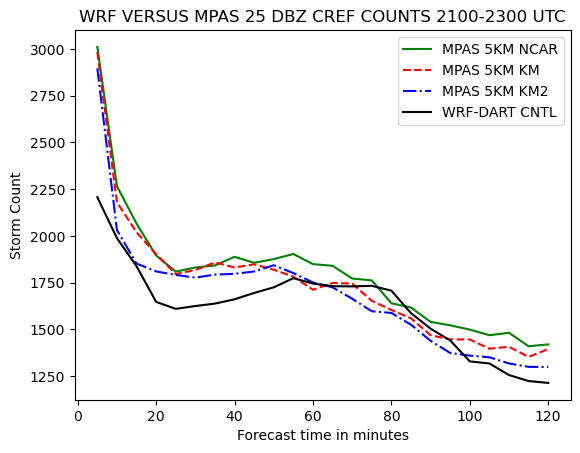

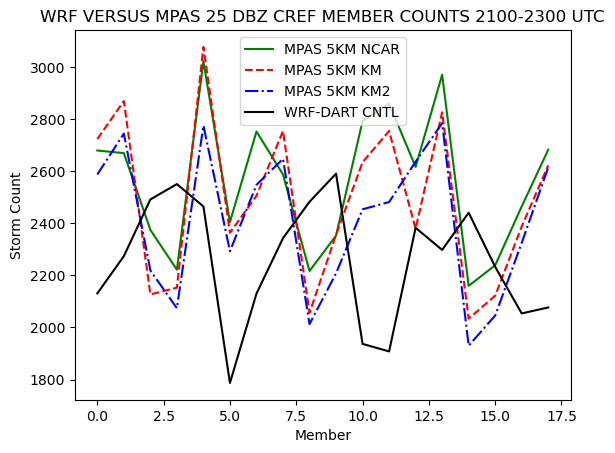

In [72]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18
min = n*5
mem = 10

runs  = [
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2100',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2100',
         '/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100'
        ]

dt_string = [2024,5,7,21]

counts  = np.zeros((len(runs), ens, nstep), dtype='int')

for r, run in enumerate(runs):

    print(f"Now computing stats for {run}")
    
    for n in np.arange(nstep):

        min = int(n*5)
    
        file_string = my_datetime(dt_string, time_delta=[0,0,min], summary_file=True)
    
    # MPAS
        
        ds = xr.open_dataset(os.path.join(run, f"wofs_ALL_{n:02}_{file_string}.nc"))
    
        counts[r,:,n] = get_counts(ds, ens, cref_thresh = cref_thresh)
        
        ds.close()


# for n in np.arange(nstep):

#     min = int(n*5)

#     file_string = my_datetime([2024,5,7,19], time_delta=[0,0,min], summary_file=True)

#     print(f"{file_string}:  5KM_NCAR: {counts[0].sum(axis=0)[n]:03}  5KM_KM: {counts[1].sum(axis=0)[n]:03}  5KM_KM2: {counts[2].sum(axis=0)[n]:03}")

time = 5*np.arange(nstep)
plt.plot(time[1:], counts[0].sum(axis=0)[1:], color='g', label='MPAS 5KM NCAR')
plt.plot(time[1:], counts[1].sum(axis=0)[1:], color='r', linestyle='--', label='MPAS 5KM KM')
plt.plot(time[1:], counts[2].sum(axis=0)[1:],  color='b', linestyle='-.', label='MPAS 5KM KM2')
plt.plot(time[1:], counts[3].sum(axis=0)[1:],  color='k', label='WRF-DART CNTL')

plt.title(f"WRF VERSUS MPAS {cref_thresh[0]} DBZ CREF COUNTS 2100-2300 UTC")
plt.xlabel('Forecast time in minutes')
plt.ylabel('Storm Count')
plt.legend()
plt.show();

time = np.arange(ens)
plt.plot(time, counts[0].sum(axis=1), color='g', label='MPAS 5KM NCAR')
plt.plot(time, counts[1].sum(axis=1), color='r', linestyle='--', label='MPAS 5KM KM')
plt.plot(time, counts[2].sum(axis=1),  color='b', linestyle='-.', label='MPAS 5KM KM2')
plt.plot(time, counts[3].sum(axis=1),  color='k', label='WRF-DART CNTL')

plt.title(f"WRF VERSUS MPAS {cref_thresh[0]} DBZ CREF MEMBER COUNTS 2100-2300 UTC")
plt.xlabel('Member')
plt.ylabel('Storm Count')
plt.legend();

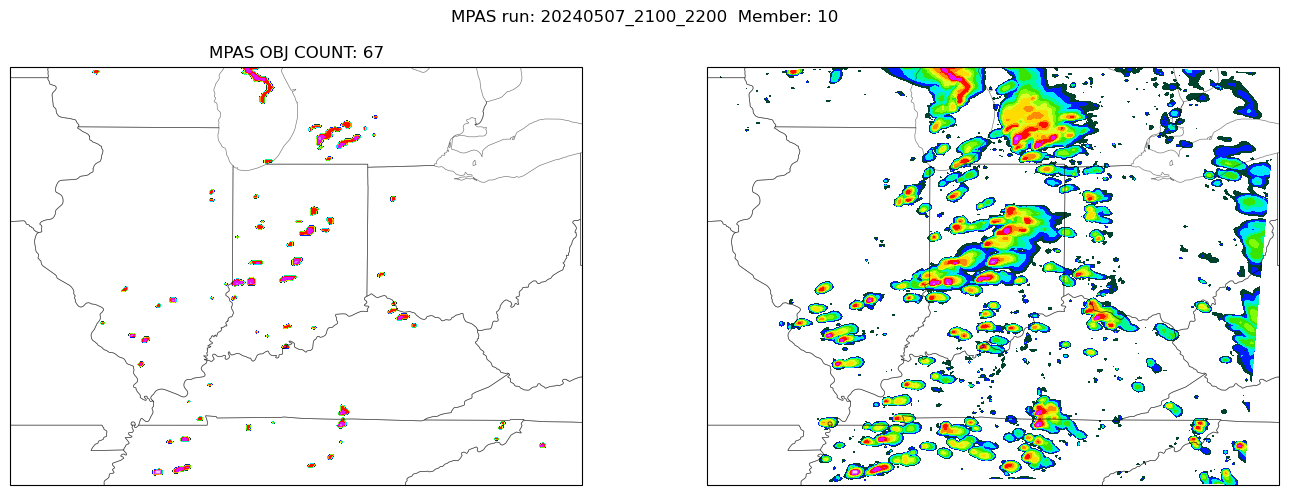

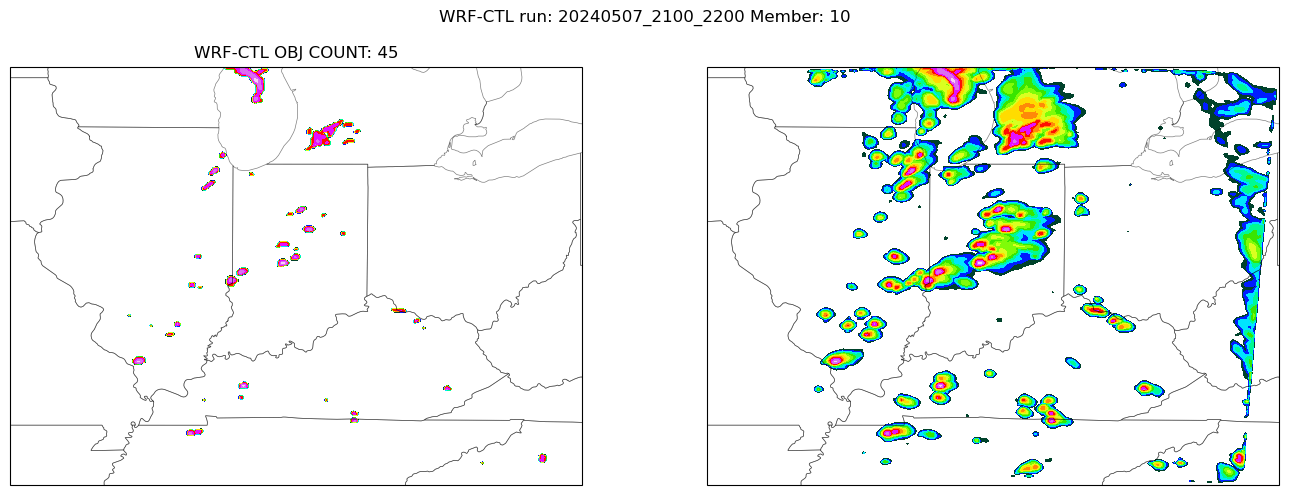

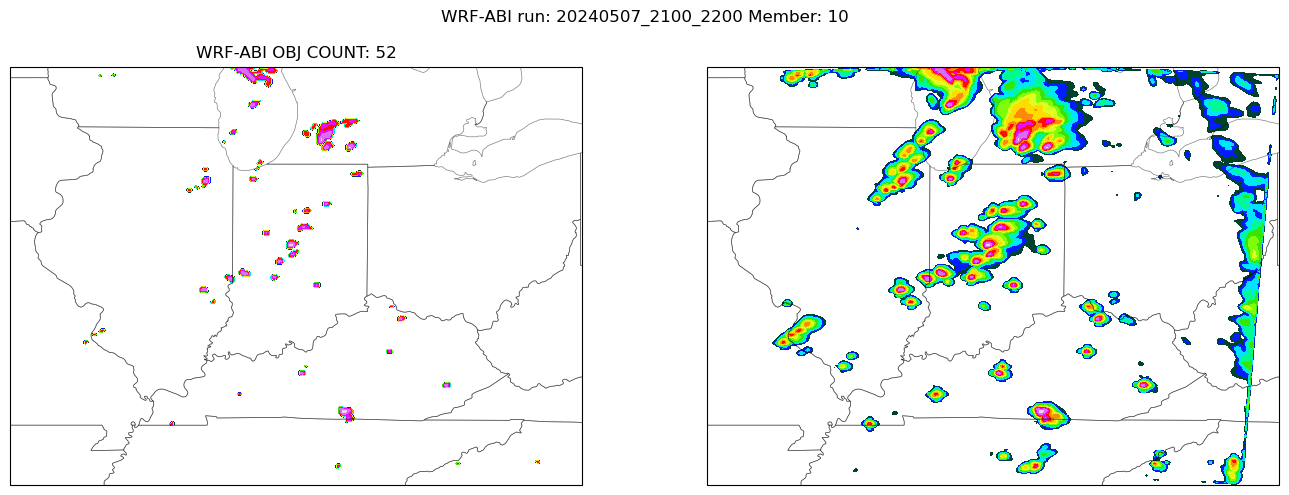

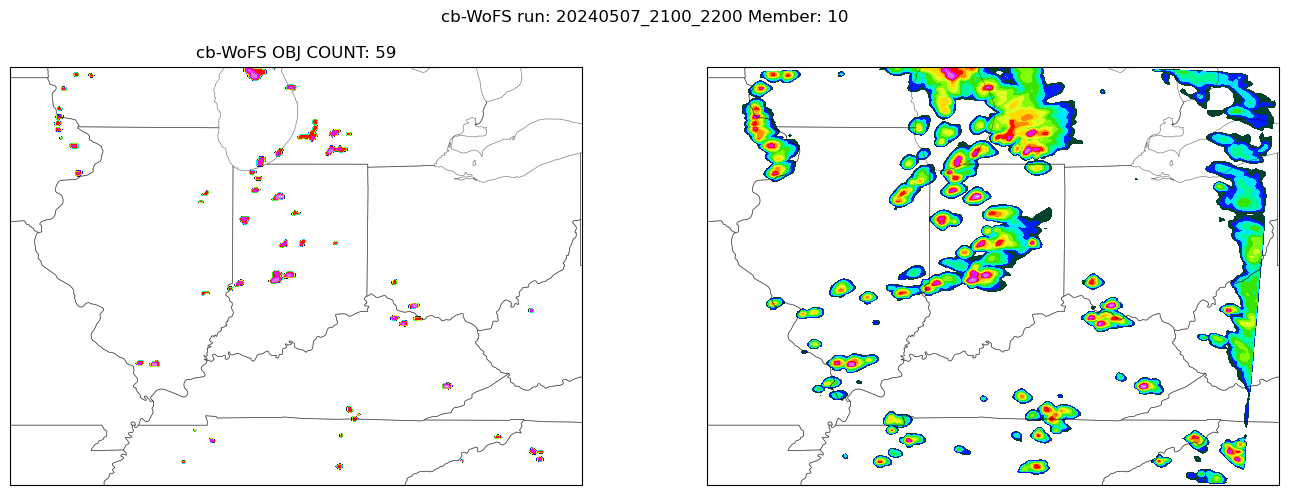

In [54]:
proj = ccrs.LambertConformal(central_longitude=-85.0, central_latitude=45.0)

n = 12
min = n*5
mem = 10

runs  = ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/1900',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/1900',
         '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900']
summary_wofs  = "/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100"
summary_wofs2 = "/work2/Thomas.Jones/POST/summary_files/20240507_ABI_V3/2100"
summary_wofs3 = "/work2/wof/realtime/SummaryFiles/2024/WOFSRun20240507-132704d1/20240507/2100"

file_string = my_datetime([2024,5,7,21], time_delta=[0,0,min], summary_file=True)

# MPAS

ds = xr.open_dataset(os.path.join(summary_mpas, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"MPAS OBJ COUNT: {mpas_count[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"MPAS run: {file_string}  Member: {mem:02}")

# WRF CTL
ds = xr.open_dataset(os.path.join(summary_wofs, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"WRF-CTL OBJ COUNT: {wrf_count[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"WRF-CTL run: {file_string} Member: {mem:02}");

#WRF-ABI
ds = xr.open_dataset(os.path.join(summary_wofs2, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"WRF-ABI OBJ COUNT: {wrf_count2[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"WRF-ABI run: {file_string} Member: {mem:02}");

# cb-wofs
ds = xr.open_dataset(os.path.join(summary_wofs3, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"cb-WoFS OBJ COUNT: {wrf_count3[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"cb-WoFS run: {file_string} Member: {mem:02}");



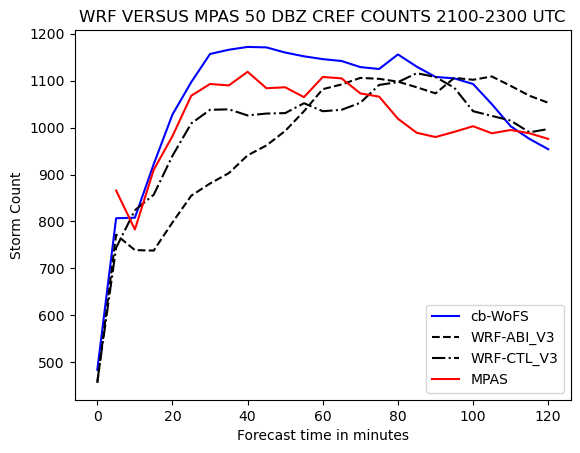

In [34]:
#------------------------------------------------------------------------------------
summary_mpas3  = '/scratch/wofs_mpas/run_dirs/20240507/fcst_5kmKM2/1900/mpassit/mem01'
summary_mpas2  = '/scratch/wofs_mpas/run_dirs/20240507/fcst_5kmKM/1900/mpassit/mem01'
summary_mpas    = '/scratch/wofs_mpas/run_dirs/20240507/fcst_5kmncar/1900/mpassit/mem01'

cref_thresh = [25,]

nstep = 25
mpas_counts = np.zeros((3,nstep), dtype='int')

for n in np.arange(nstep):

    min = int(n*5)
    print(f" MIN: {min}")

    file_string = my_datetime([2024,5,7,19], time_delta=[0,0,min], format='%Y-%m-%d_%H.%M.%S')

# MPAS
    ds = xr.open_dataset(os.path.join(summary_mpas, f"MPASSIT_01.{file_string}.nc"))

    mpas_counts[0,n] = get_counts(ds, 1, cref_thresh = cref_thresh, field_name='COMPOSITE_REFL_10CM')
    
    ds.close()

# MPAS
    ds = xr.open_dataset(os.path.join(summary_mpas2, f"MPASSIT_01.{file_string}.nc"))

    mpas_counts[1,n] = get_counts(ds, 1, cref_thresh = cref_thresh, field_name='COMPOSITE_REFL_10CM')
    
    ds.close()

# MPAS
    ds = xr.open_dataset(os.path.join(summary_mpas3, f"MPASSIT_01.{file_string}.nc"))

    mpas_counts[2,n] = get_counts(ds, 1, cref_thresh = cref_thresh, field_name='COMPOSITE_REFL_10CM')
    
    ds.close()

 MIN: 0
 MIN: 5
 MIN: 10


/tmp/ipykernel_593863/1594390527.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mpas_counts[0,n] = get_counts(ds, 1, cref_thresh = cref_thresh, field_name='COMPOSITE_REFL_10CM')
/tmp/ipykernel_593863/1594390527.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mpas_counts[1,n] = get_counts(ds, 1, cref_thresh = cref_thresh, field_name='COMPOSITE_REFL_10CM')
/tmp/ipykernel_593863/1594390527.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mpas_counts[2,n

 MIN: 15
 MIN: 20
 MIN: 25
 MIN: 30
 MIN: 35
 MIN: 40
 MIN: 45
 MIN: 50
 MIN: 55
 MIN: 60
 MIN: 65
 MIN: 70
 MIN: 75
 MIN: 80
 MIN: 85
 MIN: 90
 MIN: 95
 MIN: 100
 MIN: 105
 MIN: 110
 MIN: 115
 MIN: 120


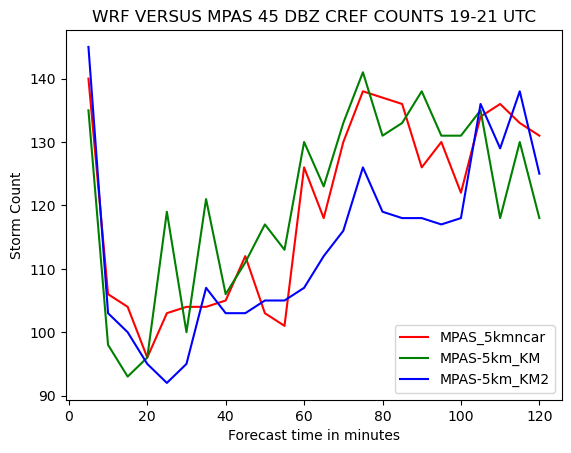

In [35]:
time = 5*np.arange(nstep)
plt.plot(time[1:], mpas_counts[0,1:], color='r', label='MPAS_5kmncar')
plt.plot(time[1:], mpas_counts[1,1:], color='g', label='MPAS-5km_KM')
plt.plot(time[1:], mpas_counts[2,1:], color='b', label='MPAS-5km_KM2')

plt.title("WRF VERSUS MPAS 45 DBZ CREF COUNTS 19-21 UTC")
plt.xlabel('Forecast time in minutes')
plt.ylabel('Storm Count')
plt.legend();